Just a little test notebook to prove I know how to code things. 

Ultimately the goal here is to efficiently compute solutions to the FTCS method for the one-directional wave equation, FTCS being Forward-Time Centered-Space. And then we want to display them in a neat way. 

First, we'll code up the correct but inefficient approach just to get everything working, outlined in https://etienneresearch.com/MATH522-s2019/notes.pdf

[[1.1253517471925912e-07, 0.00012340980408667956, 0.01831563888873418, 0.36787944117144233, 1.0, 0.36787944117144233, 0.01831563888873418, 0.00012340980408667956, 1.1253517471925912e-07, 1.3887943864964021e-11], [0.00014809176490401547, -0.0029291779215065636, -0.0429770330058251, 0.20426538098623134, 1.0, 0.5314935013566533, 0.07960831078329346, 0.003175997529679923, 2.0680833541175212e-05, 9.00281397754073e-08], [-0.003515013505807876, 0.004258342873614957, -0.0775094594904481, 0.0304358754852605, 0.945461979938263, 0.6848921162261044, 0.16766122808778905, 0.016440602521305303, 0.0005499987504645332, 1.654466683294017e-05]]


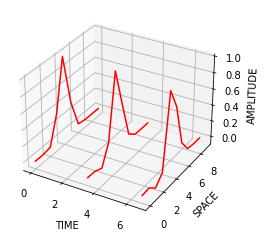

In [104]:
# Correct but inefficient method. 
from sympy import *
import math

# First, define where we are working
Maxx = 10.0 # How far can we go? Assume starting at x=0.
Nx = 10 # Our number of cells. 
Dx = Maxx / float(Nx) # Our step for x. 
Maxt = 10.0 # How far forward in time do we go?
Nt = 3 # Number of time steps. 
Dt = Maxt / float(Nt) # Our step for t. 

v = 0.1 # our wave velocity

r = Maxx/2 # for the boundary conditions we will need the "distance from center." Since we're taking 
# a rather naive approach

# From this we need to define the list of lists that will store all of our information.
# Essentially a very large matrix.
i = 0
j = 0
u = []
while i < Nt:
    u.append([])
    if i == 0:
        while j < Nx:
            u[0].append(math.exp(-((j*Dx-4)**2/(1)))) ##This sets up the initial data for t=0. 
            j += 1
            
            #While we're here, might as well list some equations that have been used here. 
            # math.sin(j*Dx) is the basic one. 
            # math.exp(-((j*Dx-5)**2/(1))) for a gaussian. 
            
    else:
        while j < Nx:
            u[i].append(0) ##Just setting everything to zero by default for non initial conditions.  
            j += 1
    i += 1
    j=0
    
# We now have a list of lists (or a matrix, really) with a set of inditial conditions 
# and the right number of open slots.
# Note for improvement: leave off defining the open slots, make them as they are needed in the program. 
# Now we need to actually implement the method. 
i = 0
j = 1

while i < Nt-1:
    while j < Nx-1:
        u[i+1][j] = u[i][j] - (v*Dt)/(2*Dx)*(u[i][j+1] - u[i][j-1])
        j += 1
    # Okay so BOUNDARY CONDITIONS! After some digging we can rather naively apply
    # The Outgoing Wave Boundary Condition to try to stop the edges from getting so hairy. 
    # Adapted from B.51
    u[i+1][0] = (r+1)/(r)*u[i][1]
    u[i+1][Nx-1] = (r-1)/(r)*u[i][Nx-2]
    # a note on these boundary conditions: they really shouldn't jsut be "one step" back, they should relate 
    # to the step size, the wave, velocity, etc.
    # But it's good enough for now. 
    i += 1
    j=1

#Technically at this point we already have what we want. 
print(u)
#Now we just need a way to display it...
#Found info from https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html
# https://www.codegrepper.com/code-examples/typescript/how+to+plot+a+3d+graph+in+graph+in+python+with+lists

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

#set an iterator variable.
tick = []
j=0
while j < Nx:
    tick.append(j * Dx) ##This sets up the initial data for t=0. 
    j += 1

#for some reason np.plot won't accept lists, so we need to convert to array.
tick2 = np.array(tick)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# These should limit the axes but apparently it will still draw off of them. 
# ax.axes.set_xlim3d(0, 10) 
# ax.axes.set_ylim3d(0, 10) 
# ax.axes.set_zlim3d(0, 10) 

i=0
while i < Nt:
    if (i % 1 == 0):
        ax.plot(np.full(Nx,i*Dt), tick2, np.array(u[i]), c='r')
    i += 1

ax.set_xlabel('TIME')
ax.set_ylabel('SPACE')
ax.set_zlabel('AMPLITUDE')



plt.show()

Now we are reminded that FTCS is guaranteed to be unstable for basically everything that isn't the static solution. We're also being quite inefficient in terms of memory that needs to be allocated to the arrays--we could be storing all the information in the plot as we go through. The tradeoff here is unknown, but we shall run comparisons between the two codes once we finish. THEN, after that, we will try to use something other than FTCS, if possible. 

[1.1253517471925912e-07, 0.00012340980408667956, 0.01831563888873418, 0.36787944117144233, 1.0, 0.36787944117144233, 0.01831563888873418, 0.00012340980408667956, 1.1253517471925912e-07, 1.3887943864964021e-11]
[0.00014809176490401547, -0.0029291779215065636, -0.0429770330058251, 0.20426538098623134, 1.0, 0.5314935013566533, 0.07960831078329346, 0.003175997529679923, 2.0680833541175212e-05, 9.00281397754073e-08]
[0.005110011448337949, 0.004258342873614957, -0.07631153935792784, 0.024880124426576666, 0.9155644371783206, 0.6708195224224912, 0.19088223159876203, 0.03498625599055007, 0.0058517084939428915, 0.004681366795154313]


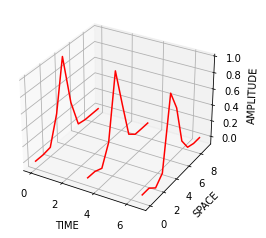

In [80]:
# Correct and efficient method
from sympy import *
import math

# First, define where we are working
Maxx = 10.0 # How far can we go? Assume starting at x=0.
Nx = 10 # Our number of cells. 
Dx = Maxx / float(Nx) # Our step for x. 
Maxt = 10.0 # How far forward in time do we go?
Nt = 3 # Number of time steps. 
Dt = Maxt / float(Nt) # Our step for t. 

v = 0.1 # our wave velocity

r = Maxx/2 # for the boundary conditions we will need the "distance from center." Since we're taking 
# a rather naive approach

# From this we need to define the lists that will store all of our information.
# Essentially a very large matrix.
i = 0
j = 0
u = []
un = [] # stores the n+1 solution. 
while j < Nx:
    u.append(math.exp(-((j*Dx-4)**2/(1)))) ##This sets up the initial data for t=0. 
    j += 1
            
            #While we're here, might as well list some equations that have been used here. 
            # math.sin(j*Dx) is the basic one. 
            # math.exp(-((j*Dx-5)**2/(1))) for a gaussian. 
print(u)
j = 0            
while j < Nx:
    un.append(0) ##Just setting everything to zero by default for non initial conditions.  
    j += 1

# We now have the two lists we need to iterate over. 
# and the right number of open slots.
# Now we need to actually implement the method. 
# The main difference here is that we're going to build the graph WHILE we run it. 

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

#set an iterator variable.
tick = []
j=0
while j < Nx:
    tick.append(j * Dx) ##This sets up the initial data for t=0. 
    j += 1

#for some reason np.plot won't accept lists, so we need to convert to array.
tick2 = np.array(tick)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# These should limit the axes but apparently it will still draw off of them. 
# ax.axes.set_xlim3d(0, 10) 
# ax.axes.set_ylim3d(0, 10) 
# ax.axes.set_zlim3d(0, 10) 

i = 0
j = 1

ax.plot(np.full(Nx,i*Dt), tick2, np.array(u), c='r') # plots the initial conditions.

while i < Nt-1:
    while j < Nx-1:
        un[j] = u[j] - (v*Dt)/(2*Dx)*(u[j+1] - u[j-1])
        j += 1
    
    # Okay so BOUNDARY CONDITIONS! After some digging we can rather naively apply
    # The Outgoing Wave Boundary Condition to try to stop the edges from getting so hairy. 
    # Adapted from B.51
    un[0] = (r+1)/(r)*u[1]
    un[Nx-1] = (r-1)/(r)*u[Nx-2]
    i += 1
    j=1
    ax.plot(np.full(Nx,i*Dt), tick2, np.array(un), c='r') # plots the next time step
    u = un # move the steps back, next loop find a new un.
    print(un)

ax.set_xlabel('TIME')
ax.set_ylabel('SPACE')
ax.set_zlabel('AMPLITUDE')

plt.show()

Their disagreement is most worrisome. We should be performing the exact same operations, yet the numbers between the above two programs do not match. 

Anyway, we now use the original program to implement a better simulation. 

[[1.2664165549094176e-14, 6.148396412704778e-14, 2.867975008888098e-13, 1.2853372251336457e-12, 5.5346100717010135e-12, 2.289734845645553e-11, 9.101470764487967e-11, 3.4758912812399344e-10, 1.2754076295260396e-09, 4.4963494622808535e-09, 1.522997974471263e-08, 4.956405319172498e-08, 1.5497531357028994e-07, 4.655715715783078e-07, 1.343812277631526e-06, 3.726653172078671e-06, 9.929504305851081e-06, 2.541934651619929e-05, 6.252150377482015e-05, 0.00014774836023203415, 0.00033546262790251185, 0.0007318024188804728, 0.0015338106793244659, 0.0030887154082367744, 0.005976022895005958, 0.011108996538242306, 0.019841094744370298, 0.03404745473459938, 0.0561347628341338, 0.08892161745938645, 0.1353352832366127, 0.19789869908361474, 0.2780373004531943, 0.37531109885139985, 0.48675225595997207, 0.6065306597126334, 0.726149037073691, 0.8352702114112722, 0.923116346386636, 0.9801986733067555, 1.0, 0.9801986733067551, 0.9231163463866356, 0.8352702114112722, 0.7261490370736905, 0.6065306597126334, 0.4

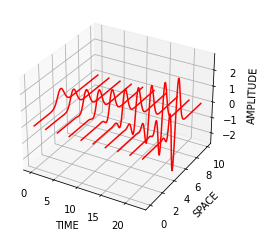

In [103]:
# Correct but inefficient method, Lax Method
from sympy import *
import math

# First, define where we are working
Maxx = 10.0 # How far can we go? Assume starting at x=0.
Nx = 100 # Our number of cells. 
Dx = Maxx / float(Nx) # Our step for x. 
Maxt = 25.0 # How far forward in time do we go?
Nt = 10 # Number of time steps. 
Dt = Maxt / float(Nt) # Our step for t. 

v = 0.1 # our wave velocity

r = Maxx/2 # for the boundary conditions we will need the "distance from center." Since we're taking 
# a rather naive approach

# From this we need to define the list of lists that will store all of our information.
# Essentially a very large matrix.
i = 0
j = 0
u = []
while i < Nt:
    u.append([])
    if i == 0:
        while j < Nx:
            u[0].append(math.exp(-((j*Dx-4)**2/(0.5)))) ##This sets up the initial data for t=0. 
            j += 1
            
            #While we're here, might as well list some equations that have been used here. 
            # math.sin(j*Dx) is the basic one. 
            # math.exp(-((j*Dx-5)**2/(1))) for a gaussian. 
            
    else:
        while j < Nx:
            u[i].append(0) ##Just setting everything to zero by default for non initial conditions.  
            j += 1
    i += 1
    j=0
    
# We now have a list of lists (or a matrix, really) with a set of inditial conditions 
# and the right number of open slots.
# Note for improvement: leave off defining the open slots, make them as they are needed in the program. 
# Now we need to actually implement the method. 
i = 0
j = 1

while i < Nt-1:
    while j < Nx-1:
        u[i+1][j] = 0.5*(u[i][j+1]+u[i][j-1]) - (v*Dt)/(2*Dx)*(u[i][j+1] - u[i][j-1])
        j += 1
    # Okay so BOUNDARY CONDITIONS! After some digging we can rather naively apply
    # The Outgoing Wave Boundary Condition to try to stop the edges from getting so hairy. 
    # Adapted from B.51
    u[i+1][0] = (r+1)/(r)*u[i][1]
    u[i+1][Nx-1] = (r-1)/(r)*u[i][Nx-2]
    i += 1
    j=1

#Technically at this point we already have what we want. 
print(u)
#Now we just need a way to display it...
#Found info from https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html
# https://www.codegrepper.com/code-examples/typescript/how+to+plot+a+3d+graph+in+graph+in+python+with+lists

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

#set an iterator variable.
tick = []
j=0
while j < Nx:
    tick.append(j * Dx) ##This sets up the initial data for t=0. 
    j += 1

#for some reason np.plot won't accept lists, so we need to convert to array.
tick2 = np.array(tick)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# These should limit the axes but apparently it will still draw off of them. 
# ax.axes.set_xlim3d(0, 10) 
# ax.axes.set_ylim3d(0, 10) 
# ax.axes.set_zlim3d(0, 10) 

i=0
while i < Nt:
    if (i % 1 == 0):
        ax.plot(np.full(Nx,i*Dt), tick2, np.array(u[i]), c='r')
    i += 1

ax.set_xlabel('TIME')
ax.set_ylabel('SPACE')
ax.set_zlabel('AMPLITUDE')



plt.show()

Below is just the same code but on a sine function.

[[0.0, 0.09983341664682815, 0.19866933079506122, 0.2955202066613396, 0.3894183423086505, 0.479425538604203, 0.5646424733950355, 0.6442176872376911, 0.7173560908995228, 0.7833269096274834, 0.8414709848078965, 0.8912073600614354, 0.9320390859672264, 0.963558185417193, 0.9854497299884603, 0.9974949866040544, 0.9995736030415051, 0.9916648104524686, 0.9738476308781951, 0.9463000876874145, 0.9092974268256817, 0.8632093666488737, 0.8084964038195901, 0.74570521217672, 0.6754631805511506, 0.5984721441039565, 0.5155013718214642, 0.4273798802338298, 0.33498815015590466, 0.23924932921398198, 0.1411200080598672, 0.04158066243329049, -0.058374143427580086, -0.15774569414324865, -0.25554110202683167, -0.35078322768961984, -0.44252044329485246, -0.5298361409084934, -0.6118578909427193, -0.6877661591839741, -0.7568024953079282, -0.8182771110644108, -0.8715757724135882, -0.9161659367494549, -0.951602073889516, -0.977530117665097, -0.9936910036334645, -0.9999232575641008, -0.9961646088358406, -0.98245261

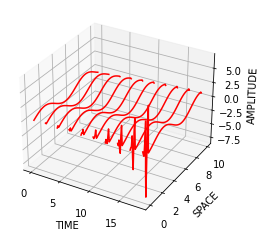

In [107]:
# Correct but inefficient method, Lax Method
from sympy import *
import math

# First, define where we are working
Maxx = 10.0 # How far can we go? Assume starting at x=0.
Nx = 100 # Our number of cells. 
Dx = Maxx / float(Nx) # Our step for x. 
Maxt = 20.0 # How far forward in time do we go?
Nt = 10 # Number of time steps. 
Dt = Maxt / float(Nt) # Our step for t. 

v = 0.1 # our wave velocity

r = Maxx/2 # for the boundary conditions we will need the "distance from center." Since we're taking 
# a rather naive approach

# From this we need to define the list of lists that will store all of our information.
# Essentially a very large matrix.
i = 0
j = 0
u = []
while i < Nt:
    u.append([])
    if i == 0:
        while j < Nx:
            u[0].append(math.sin(j*Dx)) ##This sets up the initial data for t=0. 
            j += 1
            
            #While we're here, might as well list some equations that have been used here. 
            # math.sin(j*Dx) is the basic one. 
            # math.exp(-((j*Dx-5)**2/(1))) for a gaussian. 
            
    else:
        while j < Nx:
            u[i].append(0) ##Just setting everything to zero by default for non initial conditions.  
            j += 1
    i += 1
    j=0
    
# We now have a list of lists (or a matrix, really) with a set of inditial conditions 
# and the right number of open slots.
# Note for improvement: leave off defining the open slots, make them as they are needed in the program. 
# Now we need to actually implement the method. 
i = 0
j = 1

while i < Nt-1:
    while j < Nx-1:
        u[i+1][j] = 0.5*(u[i][j+1]+u[i][j-1]) - (v*Dt)/(2*Dx)*(u[i][j+1] - u[i][j-1])
        j += 1
    # Okay so BOUNDARY CONDITIONS! After some digging we can rather naively apply
    # The Outgoing Wave Boundary Condition to try to stop the edges from getting so hairy. 
    # Adapted from B.51
    u[i+1][0] = (r+1)/(r)*u[i][1]
    u[i+1][Nx-1] = (r-1)/(r)*u[i][Nx-2]
    i += 1
    j=1

#Technically at this point we already have what we want. 
print(u)
#Now we just need a way to display it...
#Found info from https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html
# https://www.codegrepper.com/code-examples/typescript/how+to+plot+a+3d+graph+in+graph+in+python+with+lists

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

#set an iterator variable.
tick = []
j=0
while j < Nx:
    tick.append(j * Dx) ##This sets up the initial data for t=0. 
    j += 1

#for some reason np.plot won't accept lists, so we need to convert to array.
tick2 = np.array(tick)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# These should limit the axes but apparently it will still draw off of them. 
# ax.axes.set_xlim3d(0, 10) 
# ax.axes.set_ylim3d(0, 10) 
# ax.axes.set_zlim3d(0, 10) 

i=0
while i < Nt:
    if (i % 1 == 0):
        ax.plot(np.full(Nx,i*Dt), tick2, np.array(u[i]), c='r')
    i += 1

ax.set_xlabel('TIME')
ax.set_ylabel('SPACE')
ax.set_zlabel('AMPLITUDE')



plt.show()

$$ \frac{dP}{dr} = -\frac{Gm\rho}{r^2} $$
$$ \frac{dm}{dr} = 4\pi r^2 \rho$$

$$ \frac{dP}{dr} = - \frac{Gm\rho}{r^2} \left( 1 + \frac{P}{\rho c^2}\right) \left(1 + \frac{4\pi r^3 P}{mc^2} \right) \left( 1 - \frac{2Gm}{rc^2} \right)^{-1} $$

$$ G_{\mu\nu} = \kappa T_{\mu\nu} $$